In [1]:
from env import launch_env
from wrappers import NormalizeWrapper, ImgWrapper, ActionWrapper, ResizeWrapper, SteeringToWheelVelWrapper
import numpy as np
from PIL import Image
from matplotlib import cm
from matplotlib.pyplot import imshow
from matplotlib import pyplot as plt
import imageio
import cv2
import math
from math import hypot


INFO:gym-duckietown:Using gym-duckietown version 2018.8.2-more-exposure

INFO:gym-duckietown:Registering gym environment id: Duckietown-4way-v0
INFO:gym-duckietown:Registering gym environment id: Duckietown-loop_dyn_duckiebots-v0
INFO:gym-duckietown:Registering gym environment id: Duckietown-loop_empty-v0
INFO:gym-duckietown:Registering gym environment id: Duckietown-loop_obstacles-v0
INFO:gym-duckietown:Registering gym environment id: Duckietown-loop_pedestrians-v0
INFO:gym-duckietown:Registering gym environment id: Duckietown-small_loop-v0
INFO:gym-duckietown:Registering gym environment id: Duckietown-small_loop_cw-v0
INFO:gym-duckietown:Registering gym environment id: Duckietown-straight_road-v0
INFO:gym-duckietown:Registering gym environment id: Duckietown-udem1-v0
INFO:gym-duckietown:Registering gym environment id: Duckietown-zigzag_dists-v0


In [2]:
RANDOM_SEED = 1234
# Size of replay buffer
BUFFER_SIZE = 10000
MINIBATCH_SIZE = 64
raw_sim_env = launch_env(None)
env = ResizeWrapper(raw_sim_env)
env = NormalizeWrapper(env)
# to make the images pytorch-conv-compatible
env = ImgWrapper(env)
env = ActionWrapper(env)


DEBUG:gym-duckietown:Falling back to non-multisampled frame buffer
DEBUG:gym-duckietown:Falling back to non-multisampled frame buffer
DEBUG:gym-duckietown:loading map file "/Users/martinweiss/code/academic/duckietown/challenge-aido1_LF1-template-pytorch/gym-duckietown/gym_duckietown/maps/loop_empty.yaml"
DEBUG:gym-duckietown:loading mesh "/Users/martinweiss/code/academic/duckietown/challenge-aido1_LF1-template-pytorch/gym-duckietown/gym_duckietown/meshes/duckiebot.obj"
DEBUG:gym-duckietown:loading materials from "/Users/martinweiss/code/academic/duckietown/challenge-aido1_LF1-template-pytorch/gym-duckietown/gym_duckietown/meshes/duckiebot.mtl"
DEBUG:gym-duckietown:loading texture "/Users/martinweiss/code/academic/duckietown/challenge-aido1_LF1-template-pytorch/gym-duckietown/gym_duckietown/textures/floor_1.png"
DEBUG:gym-duckietown:loading texture "/Users/martinweiss/code/academic/duckietown/challenge-aido1_LF1-template-pytorch/gym-duckietown/gym_duckietown/textures/curve_left_1.png"
D

In [3]:
#state_size = (env.grid_height * env.grid_width)
#replay_buffer = RolloutStorage(100, 1, env.observation_space, env.action_space, state_size)
#env.render(mode="free_cam")
#model = DDPG(state_dim=env.observation_space.shape, action_dim=2, max_action=1, net_type="cnn")


In [4]:
def draw_lines(img, lines, color=[255, 0, 0], thickness=3):
    # If there are no lines to draw, exit.
    if lines is None:
        return
    # Make a copy of the original image.
    img = np.copy(img)
    # Create a blank image that matches the original in size.
    line_img = np.zeros(
        (
            img.shape[0],
            img.shape[1],
            3
        ),
        dtype=np.uint8,
    )
    # Loop over all lines and draw them on the blank image.
    for line in lines:
        for x1, y1, x2, y2 in line:
            cv2.line(line_img, (x1, y1), (x2, y2), color, thickness)
    # Merge the image with the lines onto the original.
    img = cv2.addWeighted(img, 0.8, line_img, 1.0, 0.0)
    # Return the modified image.
    return img

def average_slope_intercept(lines):
    left_lines    = [] # (slope, intercept)
    left_weights  = [] # (length,)
    right_lines   = [] # (slope, intercept)
    right_weights = [] # (length,)

    for line in lines:
        for x1, y1, x2, y2 in line:
            if x2==x1:
                continue # ignore a vertical line
            slope = (y2-y1)/(x2-x1)
            intercept = y1 - slope*x1
            length = np.sqrt((y2-y1)**2+(x2-x1)**2)
            if slope < 0: # y is reversed in image
                left_lines.append((slope, intercept))
                left_weights.append((length))
            else:
                right_lines.append((slope, intercept))
                right_weights.append((length))

    # add more weight to longer lines
    left_lane  = np.dot(left_weights,  left_lines) /np.sum(left_weights)  if len(left_weights) >0 else None
    right_lane = np.dot(right_weights, right_lines)/np.sum(right_weights) if len(right_weights)>0 else None

    return left_lane, right_lane # (slope, intercept), (slope, intercept)

def make_line_points(y1, y2, line):
    """
    Convert a line represented in slope and intercept into pixel points
    """
    if line is None:
        return None

    slope, intercept = line

    # make sure everything is integer as cv2.line requires it
    x1 = int((y1 - intercept)/slope)
    x2 = int((y2 - intercept)/slope)
    y1 = int(y1)
    y2 = int(y2)

    return ((x1, y1), (x2, y2))

def lane_lines(image, lines):
    left_lane, right_lane = average_slope_intercept(lines)

    y1 = image.shape[0] # bottom of the image
    y2 = y1*0.3         # slightly lower than the middle

    left_line  = make_line_points(y1, y2, left_lane)
    right_line = make_line_points(y1, y2, right_lane)

    return left_line, right_line


def draw_lane_lines(image, lines, thickness=2):
    # make a separate image to draw lines and combine with the orignal later
    line_image = np.zeros_like(image)
    colors = [[255, 0, 0], [0, 255, 0]]
    for idx, line in enumerate(lines):
        cv2.line(line_image, line[0], line[1],  colors[idx], thickness)
    return cv2.addWeighted(image, 1.0, line_image, 0.95, 0.0)



def calc_distance_lane(points):
    x1, y1, x2, y2 = deconstruct_lane_lines(points)
    return math.hypot(x2-x1, y2-y1)

def calc_distance(x1, y1, x2, y2):
    return math.hypot(x2-x1, y2-y1)

def deconstruct_lane_lines(points):
    p1, p2 = points
    x1, y1 = p1
    x2, y2 = p2
    return x1, y1, x2, y2

def slope(points):
    x1, y1, x2, y2 = deconstruct_lane_lines(points)
    return -((y2-y1)/(x2-x1))

def angle_to_action(angle):
    vel = .8
    gain = 1
    trim = 0
    radius = 0.318
    k = 27.0
    wheel_dist =.102
    limit = 1.0

    # assuming same motor constants k for both motors
    k_r = 1
    k_l = 1

    # adjusting k by gain and trim
    k_r_inv = (gain + trim) / k_r
    k_l_inv = (gain - trim) / k_l

    omega_r = (vel + 0.5 * angle * wheel_dist) / radius
    omega_l = (vel - 0.5 * angle * wheel_dist) / radius

    # conversion from motor rotation rate to duty cycle
    u_r = omega_r * k_r_inv
    u_l = omega_l * k_l_inv

    # limiting output to limit, which is 1.0 for the duckiebot
    u_r_limited = max(min(u_r, limit), .3)
    u_l_limited = max(min(u_l, limit), .3)
    action = np.array([u_l_limited, u_r_limited])
    return action



In [5]:
observation = env.reset()
action = [0, 0]


INFO:gym-duckietown:Starting at [2.75442323 0.         3.0079666 ] 4.836049502872963


[[[ 93  32 128  35]]

 [[ 39  37  73  33]]

 [[ 53  30  96  29]]

 [[  1  13  41   3]]

 [[ 54   1  82   0]]

 [[  0  51  26  40]]

 [[135 103 156  77]]

 [[122  35 159  38]]

 [[ 97   1 153  14]]

 [[138  85 158  73]]

 [[  2  51  31  39]]

 [[  7  42  44  32]]

 [[138  37 158  41]]

 [[108  30 148  36]]

 [[134 119 137  98]]

 [[128  94 156  73]]]
(((25, 120), (132, 36)), ((731, 120), (188, 36)))
left_slope:0.7850467289719626
right slope:-0.15469613259668508
-38.13357019750229
1.0
0.3


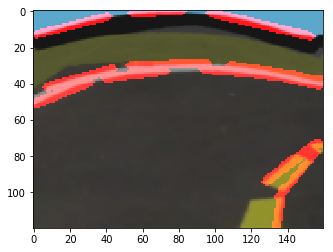

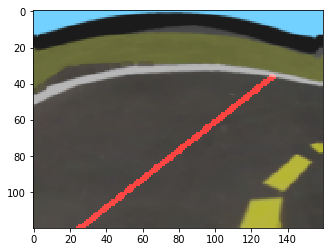

In [6]:
%matplotlib inline
for idx in range(1):
    observation, reward, done, info = env.step(action)
    observation = (np.transpose(observation, (1, 2, 0)) * 255).astype('uint8')
    i = Image.fromarray(observation, 'RGB')
    #i.save("results/" + str(idx)+'.jpg')
    #plt.figure()
    #plt.imshow(i)

    # Canny-ify
    image = cv2.dilate(observation, None)
    image = cv2.erode(image, None)
    # plt.figure()
    # plt.imshow(image)
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    r, thresh_image = cv2.threshold(gray_image, 127, 255, 1)
    cannyed_image = cv2.Canny(thresh_image, 100, 200)
    # plt.figure()
    # plt.imshow(cannyed_image)

    # Hough Lines
    lines = cv2.HoughLinesP(cannyed_image, rho=1, theta=np.pi/180, threshold=10, minLineLength=20, maxLineGap=10)
    #print(len(lines))
    line_img = draw_lines(image, lines)
    #plt.figure()
    plt.imshow(line_img)
    print(lines)
    ll = lane_lines(image, lines)
    print(ll)
    # Lane Lines
    lane_lines_image = Image.fromarray(draw_lane_lines(image, lane_lines(image, lines)), 'RGB')
    plt.figure()
    plt.imshow(lane_lines_image)

    
    # Slope Calulations
    left_lane_line = lane_lines(image, lines)[0]
    right_lane_line = lane_lines(image, lines)[1]
    #left_length = calc_distance_lane(left_lane_line)
    #right_length = calc_distance_lane(right_lane_line)

    left_slope = slope(left_lane_line)
    print("left_slope:" + str(left_slope))
    right_slope = slope(right_lane_line)
    print("right slope:" + str(right_slope))
    
    slope_to_use = right_slope
    if abs(left_slope) > abs(right_slope):
        slope_to_use = left_slope
        
    angle = -math.atan(slope_to_use) *(180 / math.pi)
    print(angle)
    action = angle_to_action(angle)
    print (action[0])
    print (action[1])

In [150]:
calc_distance(lx2, ly2, rx2, ry2)

30.0

0.8842105263157894
-1.5849056603773586


-0.7006951340615691

0.5786163522012581

In [70]:
# def region_of_interest(img, vertices):
#     mask = np.zeros_like(img)
#     match_mask_color = 255
#     cv2.fillPoly(mask, vertices, match_mask_color)
#     masked_image = cv2.bitwise_and(img, mask)
#     return masked_image

# height, width, _ = image.shape
# region_of_interest_vertices = [
#     (0, height),
#     (width / 2, height / 2),
#     (width, height),
# ]

# cropped_image = region_of_interest(
#     gray_image,
#     np.array([region_of_interest_vertices], np.int32),
# )


In [25]:
raw_sim_env.render_obs().shape

(480, 640, 3)

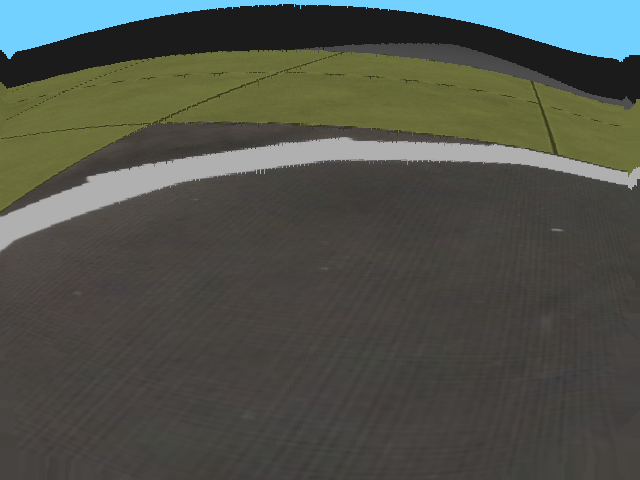

In [16]:
Image.fromarray(raw_sim_env.render_obs(), 'RGB')

In [68]:
obs_shape = env.observation_space.shape
action_space = env.action_space.shape



TypeError: 'Box' object does not support indexing